# Methodes  : ARIMA - SARIMA

ARIMA est l’un des modèles de prévision de séries chronologiques les plus classiques. Au cours du processus de modélisation, nous voulons principalement trouver 3 paramètres. Terme d'auto-régression (AR), à savoir les décalages de la valeur précédente; Terme intégral (I) pour la différenciation non stationnaire et moyenne mobile (MA) pour le terme d'erreur.


## L'objectif pour ce notebook est de :

- Comprendre ARIMA, SARIMA
- Examiner les tests nécessaires dont ARIMA a besoin pour vérifier la stationnarité
- Trouver un ensemble de paramètres à partir de tests statistiques et de visualisations

## La structure de notebook :

- Etude visuelle et classique d'une série temporelle
    - Visualisation
    - Décomposition 
- Stationnariser les données
- Interpréter ACF (FAC) et PACF (FACP)
- Déterminer p, d, q
- Ajout de la saisonnalité: SARIMA



In [0]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab style plot
import seaborn as sns # affichage, on peut utiliser d'autres librairies
import statsmodels.api as sm # modèle stat contenant le modèle ARIMA
from pylab import *
from scipy import stats
from scipy.stats import normaltest

color = sns.color_palette()
sns.set_style('darkgrid')


In [0]:
ls

TP1_eleves.ipynb                        consommation-quotidienne-brute_tr1.csv
TP1_eleves_corrigés.ipynb               donneesTP2/
TP1_eleves_corrigés.ipynb.txt           donneesTP2.zip
TP2_eleves.ipynb                        serie_temporelle_C1_20200114.pdf
TP2_eleves_corriges-2.ipynb             serie_temporelle_C2_20200114.pdf
TP2_eleves_corriges.ipynb


# Lecture des données
- Lecture du fichier csv et conversion du champ date.

Les deux premières lignes du fichier csv :
- date,store,item,sales  *(en-tête)*
- 2013-01-01,1,1,13      *(données, attention au format de la date)*

In [0]:
train = pd.read_csv('./donneesTP2/train.csv') # train data frame (panda)
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d") # dépend du format

train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


# Description
- Description de la structure du fichier (utilisation de la fonction *describe()* du dataframe
- permet d'avoir quelques informations sur les données (on remarque que les dates ne sont pas analysées)

In [0]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


On remarque qu'il y a 10 magasins et 50 produits. 

- On ajoutera 4 colonnes : l'année, le numéro du mois, le jour dans l'année et le jour de la semaine. (permettra de construire plus facile des périodes moyennes annuelle, mensuelle,hebdommadaire) et faire des boxplots
- On se restreint au magasin "1" et le produit "1" (faites votre choix)

In [0]:
# per 1 store, 1 item
train_df = train[train['store']==1] # choix du magasin
train_df = train_df[train['item']==1] # choix du produit
# train_df = train_df.set_index('date')
train_df['year'] = train['date'].dt.year # creation de la colonne année
train_df['month'] = train['date'].dt.month # creation de la colonne mois
train_df['day'] = train['date'].dt.dayofyear # creation de la  colonne jour
train_df['weekday'] = train['date'].dt.weekday # creation de la colonne jour de la semaine
# ici un numéro on pourait indiquer le jour (lundi-mardi-...)

train_df.head()

#print(train_df)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


## Décomposer la série chronologique

Pour commencer, nous voulons décomposer les données pour séparer la saisonnalité, la tendance et les résidus. 

Utilisons une fonction dans statsmodels pour nous aider à trouver la trendance.

Affichage de toutes les données

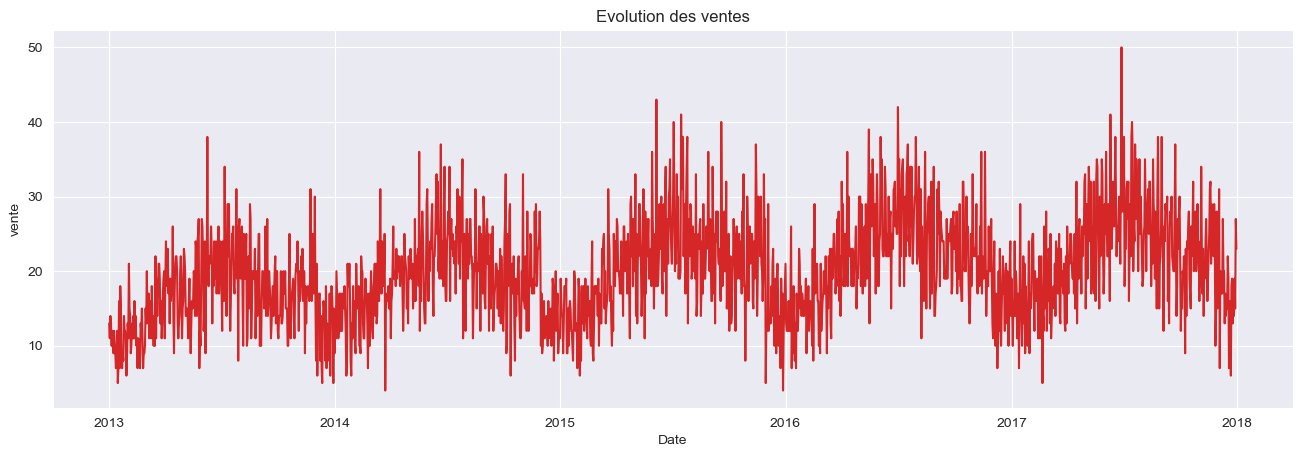

In [0]:
# sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)

# on peut utiliser les fonctions du tp1 
# faites votre choix

def plot_df(df, x, y, title="qu'est-ce ?", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(train_df, x=train_df[['date']], y=train_df[['sales']],title='Evolution des ventes',ylabel='vente') 



On remarque qu'il est possible que l'on ait une périodicité annuelle.

Affichage des 28 permières valeurs (4 semaines)

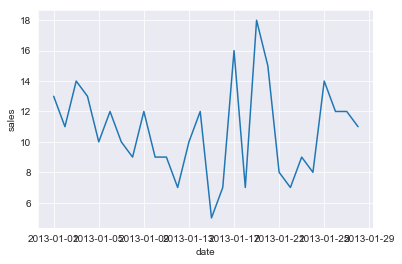

In [0]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])

Un zoom sur les 28 premiers jours montre de forte variation. Il n'y a pas de périodicité hebdommadaire apparente.

Afficher les boxplot sur les jours de la semaine, les mois

Commenter

Etude des ventes hebdomadaires par l'affichage de box plot

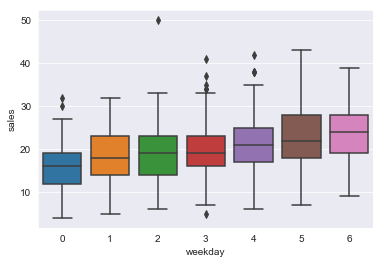

In [0]:
sns.boxplot(x="weekday", y="sales", data=train_df)


En moyenne, on peut observer une légère variation hebdommadaire.

Attention, les ventes sont à la journée la journée et ne sont pas sommées sur le mois ou l'année.

Etude des ventes annuelles

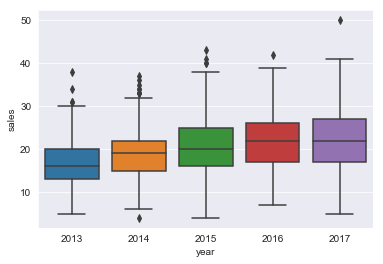

In [0]:
sns.boxplot(x="year", y="sales", data=train_df)

Légère croissance des ventes sur l'année

Etude des ventes mensuelles

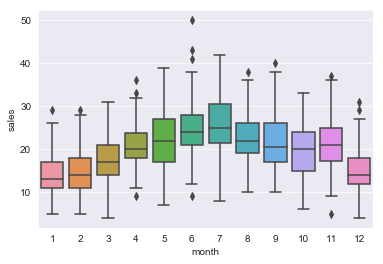

In [0]:
sns.boxplot(x="month", y="sales", data=train_df)

Pic de vente en été (la saisonnalité annuelle est bien marquée)

Transformer 'date' en index,

Transformer 'sales' en float

In [0]:
train_df = train_df.set_index('date') # pour transformer notre dataframe 
#en série temporelle avec un index temporelle
train_df['sales'] = train_df['sales'].astype(float) #pour faciliter les traitements

train_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


petite remarque : par rapport de l'affichage du dataframe la colonne donnant les indices (0,1,2,...) a disparu au profit d'une colonne nommée 'date'.

Décomposition de la série (tendance, saisonnalité, erreur) en utilisant statsmodels et seasonal_decompose

En observant la figure, on peut observer que la variance ne grandit pas ce qui laisse supposer que le modèle à choisir est plutôt addditif.

<Figure size 432x288 with 0 Axes>

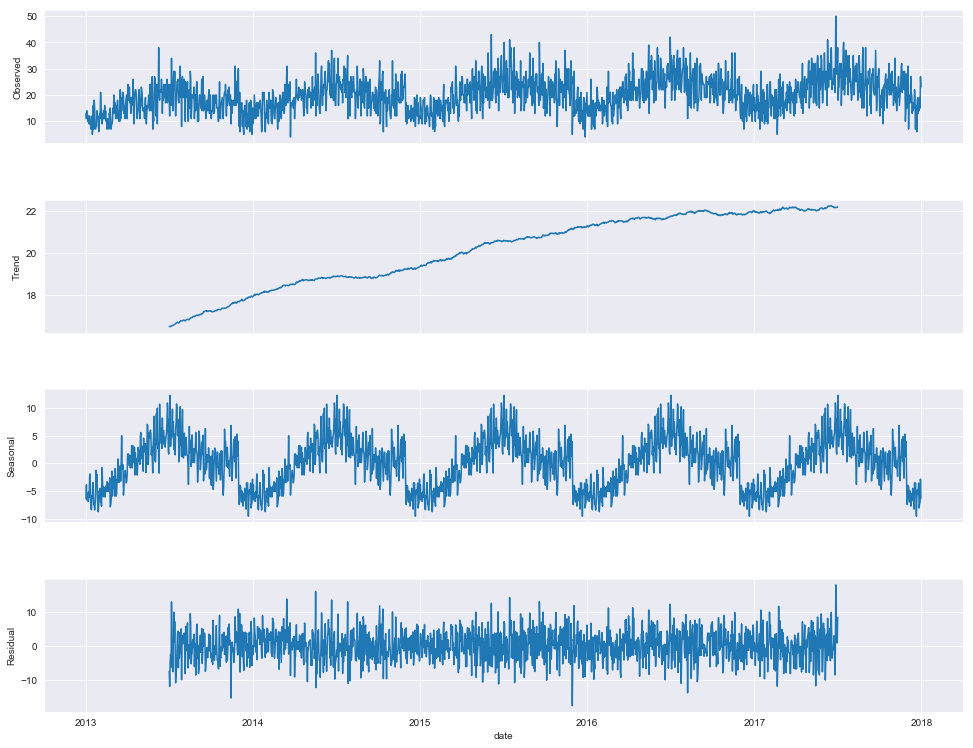

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
# utilisation de la librairie statsmodes

result = seasonal_decompose(train_df['sales'], model='additive', freq=365)
# la periodicité intuitée est annuelle
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

On observe une tendance qui augmente avec le temps (déjà observé avec les boxplot)

Le résidus semble centré avec une variance qui semble constante

# Commentaires

- la saisonnalité est bruité
- légère augmentation de la tendance

- Il faut maintenant étudier le bruit, est-il blanc ?

- Peut-on modèliser autrement ?

## Modélisation de prévision - ARIMA


Le modèle ARIMA comprend le terme AR, le terme I et le terme MA. 



La première étape est d'essayer de déterminer le terme I c'edst-à-dire la valeur de *d*

Pour cela, on teste la stionnarité de la série
- si elle est stationnaire, c'est OK, d=0
- sinon on différencie la série

On teste la stationnarité de cette différence 
- si elle est stationnaire d=1
- sinon on répète l'étape de différenciation 

Etc...

En général, on ne peut pas aller trop loin dans la répétition des différenciations (max 3 ou 4).


## Stationnarisation de la série


On peut vérifier la stationnarité d'une série chronologique de deux manières. 
- Le premier est en regardant les données. En visualisant les données, il devrait être facile d'identifier un changement de moyenne ou de variation des données. Ici, graphiquement, la série ne semble pas stationnaire.
- En utilisant le test de Dickey-Fuller, il est possible de dire si la série est stationnaire ou non. Si la «statistique de test» est supérieure à la «valeur critique», la série temporelle est stationnaire. 

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html




In [0]:
from statsmodels.tsa.stattools import adfuller

# cette fonction a été complétée afin d'observer le signal 
# et d'expliquer le résultat du test (on peut se contenter de la p-value 
# et de la valeur du test)

def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Resultats du Test de Dickey-Fuller :')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    # maxlag et autolag
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistique','p-value','#Lags utilisés','Nombre d observations utilisées'])
    for key,value in dftest[4].items():
        dfoutput['Valeur critique (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. La série est vraisemblablement stationnaire.' % pvalue)
    else:
        print('p-value = %.4f. La série est vraisemblablement non stationnaire.' % pvalue)
    
    print(dfoutput)

$\bullet$  Tester la stationnarité et commenter (on a choisi une fenêtre de 20, on peut tester d'autres valeurs ou pas)



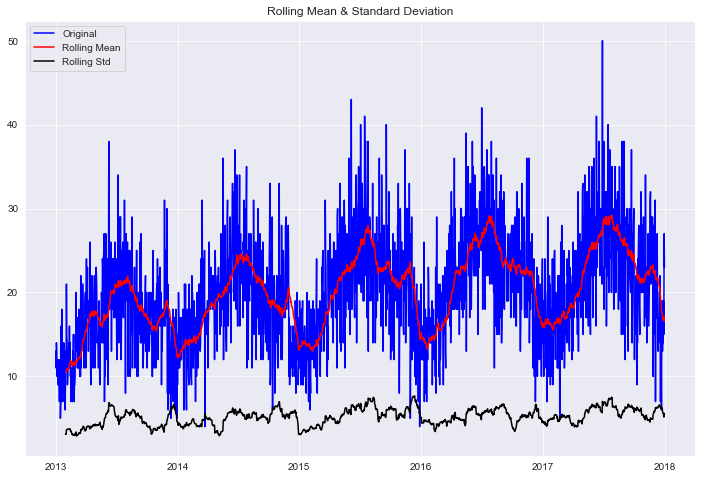

Resultats du Test de Dickey-Fuller :
p-value = 0.0361. La série est vraisemblablement non stationnaire.
Test Statistique                     -2.987278
p-value                               0.036100
#Lags utilisés                       20.000000
Nombre d observations utilisées    1805.000000
Valeur critique (1%)                 -3.433978
Valeur critique (5%)                 -2.863143
Valeur critique (10%)                -2.567623
dtype: float64


In [0]:
test_stationarity(train_df['sales'],30)

Pour que la série soit stationnaire, il faut une p-value faible et que la valeur du test soit (vraiment) inférieure à la valeur critique. Cette dernière dépend de la valeur critique.


Ici, notre valeur p est 0,036. C'est un peu élevé. 

Mais nous sommes très proches des valeurs critiques.

Si on choissit une valeur de seuil à 1%, la série n'est probablement pas stationnaire.

Si on choisit une valeur de seuil à 5% ou à 10%, la série est probablement stationnaire.

Même si le test est satisfait pour 5% et 10%, nous sommes tellement proche de la valeur de seuil que le probablement n'est pas si probable.

Plus la valeur du test est faible, plus le test est exigeant.

Ici, du fait qu'on est proche des seuils, on va différencier la série.

Pour obtenir des données stationnaires, il existe de nombreuses techniques. 

Nous pouvons utiliser la différenciation (qui est le I du modèle ARIMA)


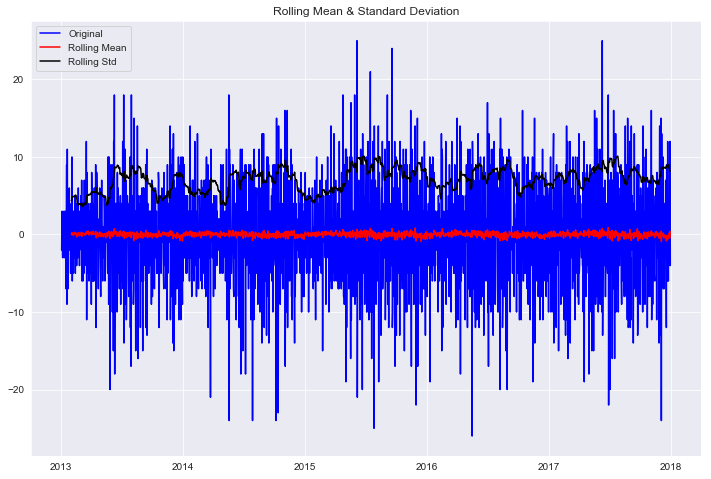

Resultats du Test de Dickey-Fuller :
p-value = 0.0000. La série est vraisemblablement stationnaire.
Test Statistique                  -1.520810e+01
p-value                            5.705031e-28
#Lags utilisés                     2.000000e+01
Nombre d observations utilisées    1.804000e+03
Valeur critique (1%)              -3.433980e+00
Valeur critique (5%)              -2.863143e+00
Valeur critique (10%)             -2.567624e+00
dtype: float64


In [0]:
first_diff = train_df.sales - train_df.sales.shift(1) # création de la série différence
first_diff = first_diff.dropna(inplace = False) # enlever les na
test_stationarity(first_diff, window = 30) # refaire le test de stationnarité

On remarque que la p-value est très très faible (c'est très bien) et que la valeur du test est vraiment inférieure aux valeurs critiques.

Ainsi, cette série est très vraisemblablement stationnaire.

et donc on peut initialiser la valeur de **d à 1**.


## ACF et PACF

L'autocorrélation partielle au décalage $k$ est la corrélation obtenue après suppression de l'effet des éventuelles corrélations dues aux termes ayant des retards plus courts.

### Modele AR

Prenons une série chronologique générée par un processus d'autorégression (AR) avec un décalage de k.

Nous nous attendons à ce que le PACF pour le processus AR(k) montre une forte corrélation avec les valeurs récentes jusqu’au décalage de k, puis un net déclin pour une corrélation faible ou nulle. 

On peut s’attendre à ce que le ACF décroit et tend vers 0



### Modèle MA

Considérons une série chronologique générée par un processus de moyenne mobile (MA) avec un décalage de k.

Nous nous attendons à ce que le ACF pour le processus MA(k) montre une forte corrélation avec les valeurs récentes jusqu’au décalage de k, puis un net déclin pour une corrélation faible ou nulle. 

On peut s’attendre à ce que le PACF décroit et tend vers 0



### Résumé

À partir du graphique d'autocorrélation, nous pouvons dire si nous devons ou non ajouter des termes MA. Nous savons, à partir du graphique d'autocorrélation partielle, que nous devons ajouter des termes AR.

Références:

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

$\bullet$ Calcul et affichage de ACF et PACF sur la série temporelle

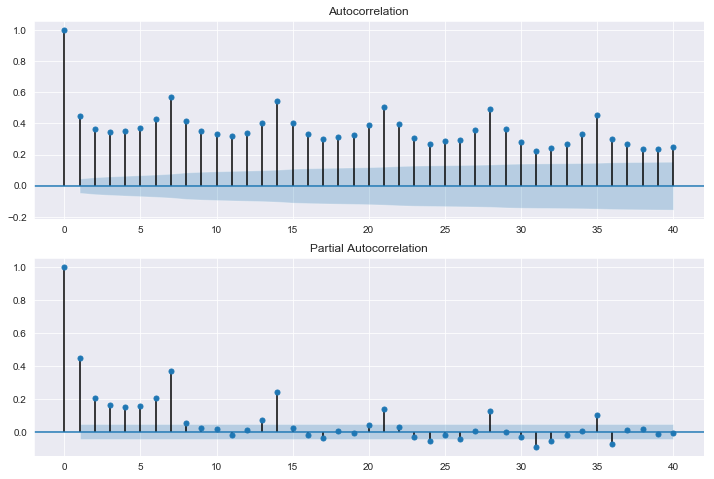

In [0]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)# , lags=40

L'ACF reste assez forte

Le PACF décroit et on voit ensuite apparaître un pic toute les 7 unités.

$\bullet$ Calcul et affichage de ACF et PACF sur la série différencier du premier ordre

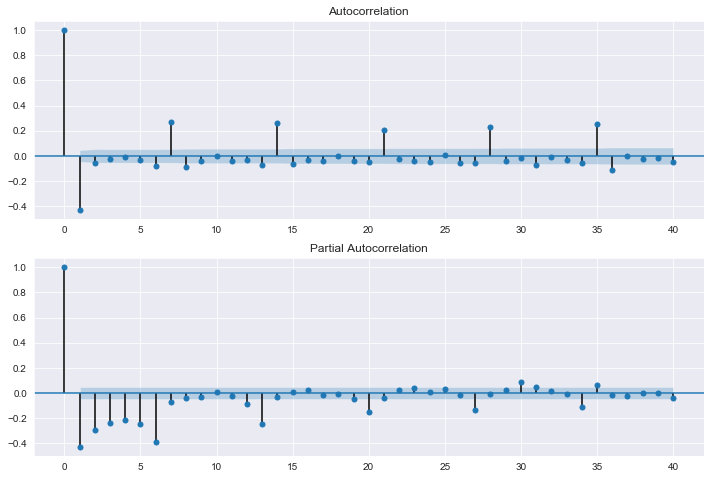

In [0]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

# Here we can see the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists. 
# Any time you see a regular pattern like that in one of these plots, you should suspect that there is some sort of 
# significant seasonal thing going on. Then we should start to consider SARIMA to take seasonality into accuont

Parce que l'autocorrélation de la série différenciée est négative à un décalage de 7, 14, 21, etc. (chaque semaine), je devrais utiliser un terme S pour le modèle.
Pour l'instant, on va oublier ce pic périodique (on y reviendra dans la modèle SARIMA).

Construire le modèle
Comment déterminer p, d, q

C'est facile à déterminer I. Dans notre cas, nous voyons la différence du premier ordre rendre tendance et saisonnalité immobiles. I = 1.

$\Rightarrow$ d = 1

Le modèle AR peut être étudié en premier avec la longueur du décalage affiché par le graphique du PACF (ou via une recherche empirique). Dans notre cas, il est clair qu'un ordre 6 est un minimum. Ce qui signifie que nous pouvons utiliser AR = 6

$\Rightarrow$ p = 6

Ce qui est intéressant, c’est que lorsque le modèle AR est spécifié de manière appropriée, les résidus de ce modèle peuvent être utilisés pour observer directement l’erreur non corrélée. Ce résidu peut être utilisé pour étudier plus en détail les spécifications des modèles MA et ARMA directement par régression.

On commence par la valeur 0, puis on étudie le ACF et PACF du résidu.

En observant l'ACF, à part les pics périodiques, on remarque que les 2 premiers coefficients ne sont pas nuls

$\Rightarrow$ q = 1


Référence:

https://www.researchgate.net/post/How_does_one_determine_the_values_for_ARp_and_MAq

https://stats.stackexchange.com/questions/281666/how-does-acf-pacf-identify-the-order-of-ma-and-ar-terms/281726#281726

https://stats.stackexchange.com/questions/134487/analyse-acf-and-pacf-plots?rq=1

In [0]:
arima_mod6 = sm.tsa.ARIMA(train_df.sales, (6,1,1)).fit(disp=True,method='css',maxiter=1000)
print(arima_mod6.summary())

resid = arima_mod6.resid
print(normaltest(resid))

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -5575.351
Method:                           css   S.D. of innovations              5.187
Date:                Fri, 24 Apr 2020   AIC                          11168.702
Time:                        06:41:59   BIC                          11218.257
Sample:                    01-08-2013   HQIC                         11186.985
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0041      0.023      0.178      0.859      -0.041       0.049
ar.L1.D.sales    -0.6340      0.059    -10.785      0.000      -0.749      -0.519
ar.L2.D.sales    -0.6175      0.047    -

Analyser le résultat

Pour voir comment notre premier modèle fonctionne, nous pouvons tracer la distribution résiduelle. Voir si c'est normal dist. Et l'ACF et PACF. Pour un bon modèle, nous voulons voir que le résidu est une distribution normale. Et ACF, PACF n'a pas de termes significatifs.

NormaltestResult(statistic=13.794327392712951, pvalue=0.00101064787199255)


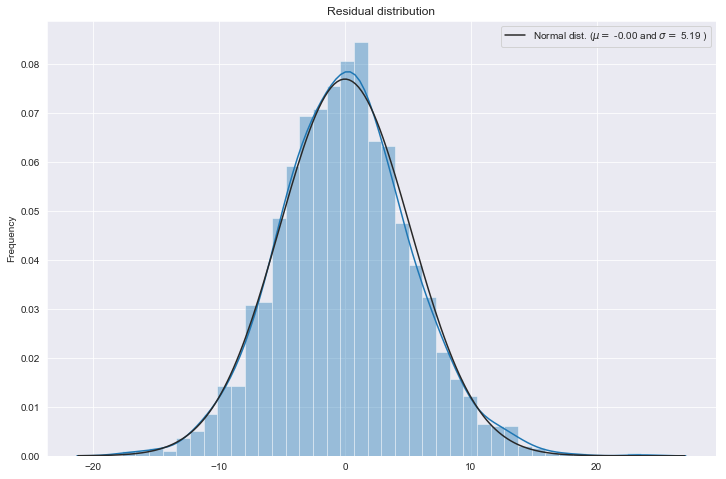

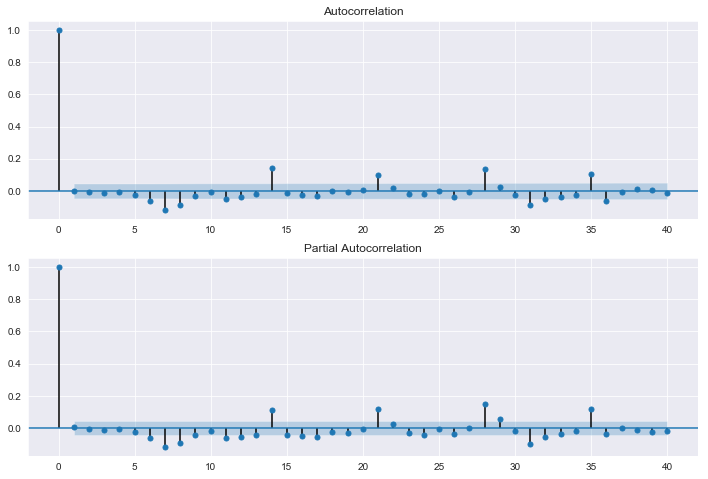

In [0]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)


#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))


ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

On remarque que l'histogramme du résidu est plutôt gaussien (confirmé par un test sur la normalité)

A part les pics périodiques (non inclus dans le modèle, l'ACF ressemble à l'ACF d'un bruit blanc.

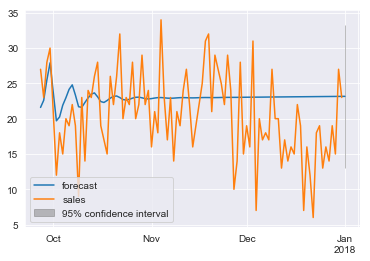

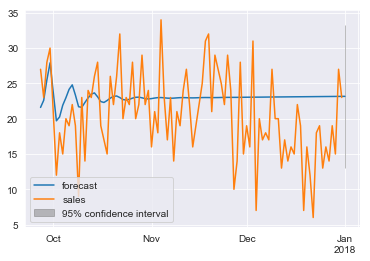

In [0]:
start_index = 1730
end_index = 1826
arima_mod6.plot_predict(start = start_index, end= end_index, dynamic= True)  



On peut également tester q = 1. 

Bien que le graphique ressemble beaucoup à une distribution normale, celle-ci a échoué au test. Nous constatons également une corrélation récurrente dans ACF et PACF (toutes les 7 unités). Nous devons donc faire face à la saisonnalité.

Considérez la saisonnalité affectée par SARIMA

On choisira une valeur de s=7

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
https://barnesanalytics.com/sarima-models-using-statsmodels-in-python

In [0]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(train_df.sales, trend = 'c', order=(6,1,1), seasonal_order=(1,1,1,7)).fit()
print(sarima_mod6.summary())

resid = sarima_mod6.resid
print(normaltest(resid))

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                 1826
Model:             SARIMAX(6, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -5393.771
Date:                           Fri, 24 Apr 2020   AIC                          10809.541
Time:                                   06:42:23   BIC                          10870.101
Sample:                               01-01-2013   HQIC                         10831.885
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.000     -0.789      0.430      -0.001       0.000
ar.L1          0.0099      0.034      0.293

NormaltestResult(statistic=18.939646446229496, pvalue=7.71450437377202e-05)


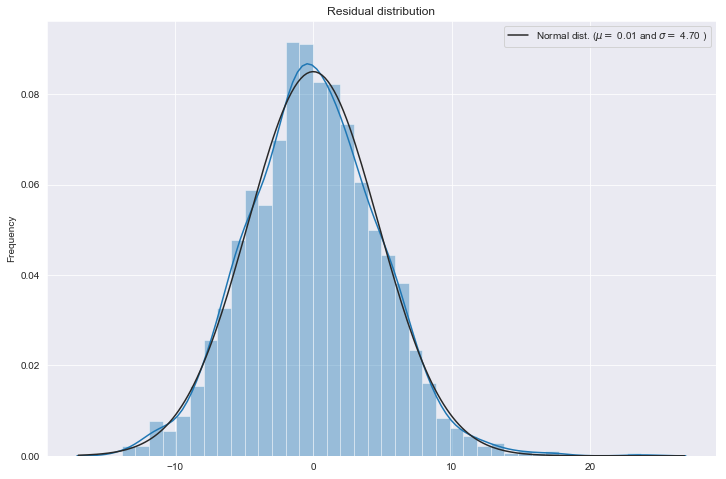

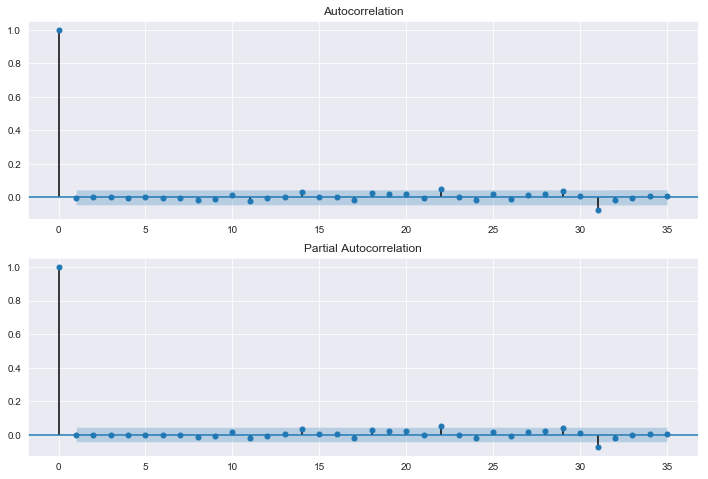

In [0]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima_mod6.resid, lags=35, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima_mod6.resid, lags=35, ax=ax2)

On a réussi à éliminer les pics périodiques.

Le résidu a une forme plus "gaussien".

L'ACF : il ne reste qu'un pic en 0.

Faire des prévisions et des évaluations

Prendre les 30 derniers jours d’entraînement définis comme données de validation

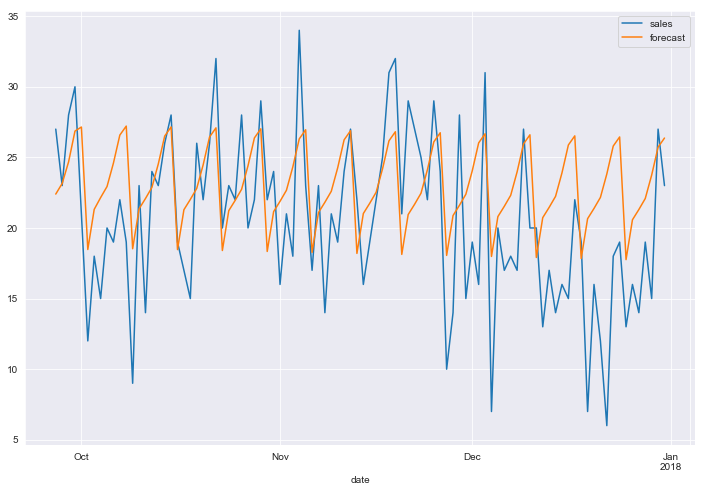

In [0]:
start_index = 1730
end_index = 1826
train_df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

On voit que la prédiction n'est pas top mais est-ce que les données étaient coopérantes ?

In [0]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [0]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

MAPE: 39.50 % 
SMAPE: 54.08 %


## LSTM model 

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
def build_MLP( input_shape, activation = 'relu', units = [100,100], momentum=0.1, epsilon=1e-05, dropout_rate = 0,
              optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy']):
    
    """
    build a neural network with linear blocks fellowed by non linear activations. Every block consists of
     BatchNormalization, Dropout and a  dense layer. The depth of the network can be custumized in parameter "units"


  	Parameters:
    ----------

  	input_shape : tuple of integers.
        Correspond to the shape of the input samples.
    units: list of integers.
        Define the number of units of every linear block of the network. Thus len(units) define the depth of the network. If "units" is an empty list, the built model correspond to a logistic regression preceded by a BatchNormalization.

	Return:
    ------

	model : Keras Sequential object
			Compiled model with a binary crossentropy loss and accuracy metric.

    Author : Amine  
    """


    model = Sequential()
    model.add(BatchNormalization(axis=1, momentum=momentum, epsilon=epsilon, input_shape = input_shape))
    
    for n_units in units: 
      model.add(Dropout(dropout_rate))
      model.add(Dense(units=n_units,  activation=activation))
      model.add(BatchNormalization(axis=1, momentum=momentum, epsilon=epsilon))

    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='softmax'))     
    
    model.compile(loss= loss , 
                      optimizer=optimizer, 
                      metrics=metrics)
    
    

    return model


def build_CNN(input_shape, filters= [3], kernels = [4], activation = 'relu', optimizer= 'Adam'):
    
    """
    build a  convolutionnal neural network . Every block consists of BatchNormalization, Dropout and a 
    1 dimensionnal   convolution. The depth of the network can be custumized in parameters  "kernels" 
    and "filters". It correspond to max ( len(filters), len(kernels)).


    Parameters:
    ----------
    input_shape : tuple of integers
        Correspond to the shape of the input samples.
    filters: list of integers
        Define the number of filters  of every 1 dimensionnal convolution. 
    kernels : list of integers
        Define the kernel size of the filters  of every 1 dimensionnal convolution. 
    Return:
    ------

    model : Keras Sequential object
        Compiled model with a binary crossentropy loss and accuracy metric.
    Author : Amine.  
    """
    model = Sequential()
    model.add(BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, input_shape = input_shape))
    model.add( Conv1D(filters=3, kernel_size= 4, strides =1, activation = activation))
    for (f, k) in zip(filters, kernels):
        
        model.add(BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05))
        model.add(Dropout(0.1))
        model.add(Conv1D(filters=f, kernel_size= k, strides =1, activation = activation))
        model.add(MaxPooling1D())

    model.add(Flatten())
    model.add(BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05))
    model.add(Dropout(0.1))
    model.add(Dense(units=1, activation='sigmoid')) 



    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


    return model 



In [0]:
def dense_block(activation = 'relu', units = [100,100, 1], momentum=0.1, epsilon=1e-05, dropout_rate = 0.3):
    
    
    layers = [tf.keras.layers.BatchNormalization( momentum=momentum, epsilon=epsilon)]
    
    for n_units in units[:-1]:
        
        layers.append(tf.keras.layers.Dropout(dropout_rate))
        layers.append(tf.keras.layers.Dense(units=n_units,  activation=activation))
        layers.append(tf.keras.layers.BatchNormalization (momentum=momentum, epsilon=epsilon))
    layers.append(tf.keras.layers.Dense(units=units[-1]))
    return layers
    

In [0]:
def conv1d_bolck( filters= [3], kernels = [4], stride = 1,  activation = 'relu', 
                  dropout_rate = 0.3):
    layers = []
    for (f, k) in zip(filters, kernels):
        
        layers.append(tf.keras.layers.BatchNormalization( momentum=0.1, epsilon=1e-05))
        layers.append(tf.keras.layers.Dropout(dropout_rate))
        layers.append(tf.keras.layers.Conv1D(filters=f, kernel_size= k, strides =stride, padding = "causal", activation = activation))
       # layers.append(tf.keras.layers.MaxPooling1D())
    
    
    return layers

In [0]:
def lstm_block( activation = 'relu', units = [100,100, 1], momentum=0.1, epsilon=1e-05,dropout_rate = 0.3 ):
    layers = []
    for n_units in units:
        
        layers.append(tf.keras.layers.Dropout(dropout_rate))
        layers.append(tf.keras.layers.LSTM(units=n_units,  activation=activation, return_sequences=True ))
    
    return layers

In [0]:
from tensorflow.keras import layers

class ScaleLayer(layers.Layer):
    def __init__(self):
        super(ScaleLayer, self).__init__()

        w_init = tf.random_normal_initializer()

        self.scale = tf.Variable(initial_value=w_init(shape=(1,),
                                              dtype='float32'),
                         trainable=True)


    def call(self, inputs):
        return inputs * self.scale
    
    def get_config(self):
        return {'scale': self.scale}



In [0]:
import keras
from keras.layers import *

from keras.models import Sequential

Using TensorFlow backend.


In [0]:
x_train = train_df.sales; x_train.shape

(1826,)

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 12
batch_size = 50
shuffle_buffer_size = 500
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1826,)


In [0]:
model = tf.keras.models.Sequential(
    [tf.keras.layers.InputLayer(input_shape=(None, 1))] +
    conv1d_bolck( filters= [32], kernels = [5], stride = 1,  activation = 'relu', 
                  dropout_rate = 0.3) +
    lstm_block( activation = 'relu', units = [64,1]) +
    dense_block( activation = 'relu', units = [30,10, 1], dropout_rate = 0.3) +
    [ScaleLayer()]
)

model.summary()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae", "MAPE"])
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])

[1e-08, 0.01, 0, 60]

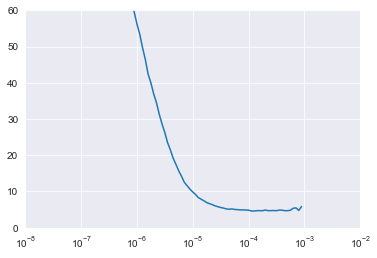

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 60])

In [0]:
model = tf.keras.models.Sequential(
    [tf.keras.layers.InputLayer(input_shape=(None, 1))] +
    conv1d_bolck( filters= [32], kernels = [5], stride = 1,  activation = 'relu', 
                  dropout_rate = 0.3) +
    lstm_block( activation = 'relu', units = [64,64]) +
    dense_block( activation = 'relu', units = [1,10, 1], dropout_rate = 0.3) +
    [ScaleLayer()]
)
optimizer = tf.keras.optimizers.SGD(lr=2*1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae", "MAPE"])
history = model.fit(train_set,epochs=40)

In [0]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae", "MAPE"])
history = model.fit(train_set,epochs=2)

Epoch 1/2
37/37 [==============================] - 4s 108ms/step - loss: 4.1656 - mae: 4.6234 - MAPE: 26.9770
Epoch 2/2
37/37 [==============================] - 1s 24ms/step - loss: 4.1259 - mae: 4.6034 - MAPE: 27.0585


In [0]:
ls

Hackathon_Sujet_1_data.zip  sample_data/


# Application on S&P 500 closing behaviour

In [0]:
rcParams['figure.figsize'] = 24, 13

In [0]:
from zipfile import *
zip = ZipFile('Hackathon_Sujet_1_data.zip')
zip.extractall() 

In [0]:
cd Hackathon_Sujet_1_data

/content/Hackathon_Sujet_1_data


In [0]:
ls

sp-explanatory-test.csv   sp-explanatory-valid.csv
sp-explanatory-train.csv  sp-response-train.csv


## Data preparation and visualisation

In [0]:
sp_train = pd.read_csv("sp-explanatory-train.csv")
col_names = sp_train.columns
sp_y_train = pd.read_csv("sp-response-train.csv")
sp_test = pd.read_csv("sp-explanatory-test.csv", names =col_names)
sp_val= pd.read_csv("sp-explanatory-valid.csv", names =col_names )
sp_test.head()

,openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,closeMin009,closeMin010,closeMin011,closeMin012,closeMin013,closeMin014,closeMin015,closeMin016,closeMin017,closeMin018,closeMin019,closeMin020,closeMin021,closeMin022,closeMin023,closeMin024,closeMin025,closeMin026,closeMin027,closeMin028,closeMin029,closeMin030,closeMin031,closeMin032,closeMin033,closeMin034,closeMin035,closeMin036,closeMin037,closeMin038,...,closeMin201,closeMin202,closeMin203,closeMin204,closeMin205,closeMin206,closeMin207,closeMin208,closeMin209,closeMin210,closeMin211,closeMin212,closeMin213,closeMin214,closeMin215,closeMin216,closeMin217,closeMin218,closeMin219,closeMin220,closeMin221,closeMin222,closeMin223,closeMin224,closeMin225,closeMin226,closeMin227,closeMin228,closeMin229,closeMin230,closeMin231,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240
0,140150625,123078282,100,100.0456,100.0182,100.0638,100.0729,100.0638,100.0456,100.0547,100.0911,100.1093,100.1276,100.1185,100.1367,100.1276,100.1549,100.1185,100.1093,100.1367,100.1549,100.1913,100.2005,100.1822,100.1913,100.2369,100.2460,100.2187,100.2369,100.2369,100.2551,100.2733,100.2460,100.2551,100.2642,100.2369,100.2187,100.2369,100.2551,100.2916,...,100.4556,100.4009,100.4191,100.4647,100.4647,100.4556,100.5285,100.5011,100.4829,100.4465,100.4465,100.4647,100.4465,100.4282,100.4282,100.4191,100.4556,100.4374,100.4282,100.4556,100.4920,100.4920,100.5194,100.4556,100.4647,100.5103,100.4647,100.4647,100.5831,100.5649,100.5831,100.6105,100.5923,100.5831,100.5923,100.5649,100.5376,100.5376,100.5558,100.5649
1,131474897,77664097,100,99.9890,99.9781,99.9890,99.9890,100.0000,100.0000,100.0000,99.9890,99.9781,99.9781,99.9781,99.9671,99.9890,99.9671,99.9781,100.0000,99.9890,99.9781,99.9781,99.9890,99.9781,99.9781,99.9890,99.9781,99.9781,99.9890,99.9890,99.9890,99.9781,99.9781,99.9671,99.9671,99.9781,99.9781,99.9890,99.9671,99.9781,...,100.5484,100.5484,100.5484,100.5265,100.5375,100.5265,100.5265,100.5265,100.5375,100.5265,100.5484,100.5813,100.5923,100.5813,100.5923,100.5813,100.6142,100.6252,100.5923,100.6033,100.5923,100.6033,100.6362,100.6033,100.5923,100.5923,100.6033,100.6033,100.6033,100.5923,100.5923,100.5704,100.5375,100.5155,100.4936,100.5155,100.5265,100.5265,100.5375,100.5265
2,70777365,56312513,100,99.9872,99.9745,99.9745,99.9872,99.9745,99.9617,99.9489,99.9489,99.9362,99.9362,99.9362,99.9234,99.9234,99.9234,99.9362,99.9234,99.9362,99.9362,99.9234,99.9234,99.9106,99.9106,99.8851,99.8979,99.8723,99.8596,99.8468,99.8468,99.8723,99.8851,99.8979,99.8851,99.8979,99.8723,99.8723,99.8596,99.8723,...,100.1277,100.1532,100.2426,100.2298,100.2554,100.2937,100.2681,100.3064,100.3192,100.3192,100.3192,100.3320,100.3320,100.3320,100.3192,100.3064,100.3192,100.3320,100.2937,100.2809,100.2809,100.2937,100.3064,100.3192,100.3320,100.3320,100.3703,100.3703,100.3830,100.3447,100.3575,100.3703,100.3320,100.3320,100.3192,100.3192,100.3192,100.3192,100.3320,100.3192
3,93488804,56667536,100,100.0000,100.0000,100.0000,100.0134,100.0134,99.9866,100.0000,100.0000,100.0000,100.0000,100.0134,100.0000,100.0000,100.0134,100.0000,99.9733,99.9599,99.9466,99.9332,99.9332,99.9599,99.9599,99.9599,99.9733,99.9733,99.9733,99.9866,99.9866,99.9866,99.9866,99.9599,99.9733,99.9733,99.9733,99.9599,99.9466,100.0000,...,99.9466,99.9332,99.9466,99.9065,99.9332,99.9599,99.9199,99.8798,99.9332,99.9065,99.9199,99.9199,99.9733,99.9599,99.9599,99.9199,99.9199,99.9466,99.9065,99.9332,99.9199,99.9199,99.9065,99.8397,99.7997,99.8264,99.7997,99.8397,99.8264,99.8397,99.8932,99.8665,99.8932,99.8932,99.9332,99.9733,99.9466,99.9733,99.9866,100.0000
4,197333777,122747762,100,99.9829,99.9914,99.9914,99.9829,99.9829,99.9914,99.9829,100.0000,100.0000,99.9914,99.9914,100.0000,100.0000,99.9743,99.9743,99.9657,99.9829,99.9743,99.9829,99.9829,99.9829,99.9829,99.9743,99.9743,99.9743,99.9657,99.9657,99.9657,99.9657,99.9571,99.957

In [0]:
sp_train.head()

,openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,closeMin009,closeMin010,closeMin011,closeMin012,closeMin013,closeMin014,closeMin015,closeMin016,closeMin017,closeMin018,closeMin019,closeMin020,closeMin021,closeMin022,closeMin023,closeMin024,closeMin025,closeMin026,closeMin027,closeMin028,closeMin029,closeMin030,closeMin031,closeMin032,closeMin033,closeMin034,closeMin035,closeMin036,closeMin037,closeMin038,...,closeMin201,closeMin202,closeMin203,closeMin204,closeMin205,closeMin206,closeMin207,closeMin208,closeMin209,closeMin210,closeMin211,closeMin212,closeMin213,closeMin214,closeMin215,closeMin216,closeMin217,closeMin218,closeMin219,closeMin220,closeMin221,closeMin222,closeMin223,closeMin224,closeMin225,closeMin226,closeMin227,closeMin228,closeMin229,closeMin230,closeMin231,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240
0,131500151,73564094,100,100.0000,99.9877,100.0000,99.9877,99.9877,99.9754,100.0000,100.0123,100.0123,100.0123,100.0123,100.0369,100.0369,100.0246,100.0123,100.0123,100.0123,100.0123,100.0246,100.0123,100.0123,100.0123,100.0000,100.0246,100.0369,100.0615,100.0492,100.0246,100.0246,100.0369,100.0492,100.0123,100.0000,100.0246,100.0369,100.0492,100.0369,...,100.0861,100.0984,100.1107,100.1599,100.1476,100.2091,100.1845,100.2091,100.1845,100.2337,100.2091,100.1968,100.1722,100.1476,100.1353,100.1599,100.1599,100.1107,100.0984,100.0861,100.0615,100.0369,100.0615,100.0984,100.0615,100.0984,100.0738,100.0861,100.0984,100.1599,100.1476,100.1353,100.1353,100.1107,100.0984,100.0738,100.0615,100.0369,100.0246,99.9877
1,49061693,68383750,100,99.9900,99.9801,100.0000,99.9602,100.0000,100.0000,100.0000,100.0000,99.9701,99.9602,99.9900,99.9801,99.9801,99.9801,100.0100,100.0299,100.0199,100.0398,100.0498,100.0598,100.0598,100.0598,100.0697,100.0398,100.0398,100.0299,100.0398,100.0299,100.0398,100.0100,100.0000,99.9900,99.9900,99.9701,99.9602,99.9502,99.8606,...,99.3127,99.3227,99.3227,99.3426,99.2629,99.2629,99.3028,99.2629,99.2430,99.2829,99.2430,99.2231,99.2629,99.3227,99.3625,99.3028,99.3227,99.3327,99.3725,99.3028,99.2231,99.1932,99.2032,99.1633,99.2131,99.1434,99.2430,99.2131,99.2530,99.2032,99.0936,99.0837,99.0637,99.0538,99.0637,99.1434,99.1733,99.2131,99.2131,99.3028
2,79306648,96243823,100,100.0244,99.9878,99.9634,99.9512,99.9634,100.0000,100.0000,100.0000,100.0000,100.0366,100.0366,100.0488,100.0977,100.1465,100.1709,100.1587,100.1709,100.1709,100.1587,100.1465,100.1343,100.1465,100.1587,100.1587,100.1587,100.1099,100.1221,100.1343,100.1221,100.1099,100.0977,100.0855,100.0977,100.0977,100.0855,100.0733,100.0733,...,100.0122,100.0244,100.0244,100.0488,100.0244,100.0000,100.0000,100.0000,100.0366,100.0244,100.0000,100.0366,100.0733,100.0733,100.0855,100.1221,100.0855,100.1099,100.0977,100.1465,100.1709,100.1465,100.1221,100.1221,100.1099,100.1221,100.1221,100.1343,100.1099,100.0733,100.1099,100.0855,100.1099,100.0977,100.0977,100.0855,100.0733,100.0977,100.1099,100.1465
3,190750562,93258399,100,100.0000,99.9896,99.9896,99.9896,99.9896,99.9791,99.9896,100.0104,100.0104,100.0104,100.0000,99.9896,99.9896,99.9791,99.9791,99.9791,99.9791,99.9687,99.9687,99.9583,99.9583,99.9479,99.9583,99.9687,99.9583,99.9583,99.9479,99.9374,99.9374,99.9479,99.9583,99.9479,99.9374,99.9374,99.9270,99.9374,99.9270,...,99.8123,99.8123,99.7914,99.7601,99.7705,99.7705,99.7810,99.8018,99.7914,99.7914,99.8123,99.8123,99.8123,99.8123,99.8018,99.8123,99.8018,99.8123,99.8123,99.7914,99.7705,99.7705,99.7705,99.7601,99.7497,99.7705,99.7810,99.7705,99.7705,99.7601,99.7705,99.7393,99.7288,99.7288,99.7184,99.7288,99.7184,99.7080,99.7184,99.7184
4,209460450,142983394,100,100.0000,99.9909,99.9909,99.9818,99.9818,99.9909,99.9909,100.0091,100.0273,100.0182,100.0273,100.0000,99.9818,100.0091,100.0182,100.0273,100.0364,100.0273,99.9909,99.9909,99.9909,99.9909,99.9909,100.0000,100.0273,100.0182,100.0182,100.0000,99.9909,99.9818,

In [0]:
df_train = sp_train
df_train["Target"]= sp_y_train;df_train.head()

,openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,closeMin009,closeMin010,closeMin011,closeMin012,closeMin013,closeMin014,closeMin015,closeMin016,closeMin017,closeMin018,closeMin019,closeMin020,closeMin021,closeMin022,closeMin023,closeMin024,closeMin025,closeMin026,closeMin027,closeMin028,closeMin029,closeMin030,closeMin031,closeMin032,closeMin033,closeMin034,closeMin035,closeMin036,closeMin037,closeMin038,...,closeMin202,closeMin203,closeMin204,closeMin205,closeMin206,closeMin207,closeMin208,closeMin209,closeMin210,closeMin211,closeMin212,closeMin213,closeMin214,closeMin215,closeMin216,closeMin217,closeMin218,closeMin219,closeMin220,closeMin221,closeMin222,closeMin223,closeMin224,closeMin225,closeMin226,closeMin227,closeMin228,closeMin229,closeMin230,closeMin231,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240,Target
0,131500151,73564094,100,100.0000,99.9877,100.0000,99.9877,99.9877,99.9754,100.0000,100.0123,100.0123,100.0123,100.0123,100.0369,100.0369,100.0246,100.0123,100.0123,100.0123,100.0123,100.0246,100.0123,100.0123,100.0123,100.0000,100.0246,100.0369,100.0615,100.0492,100.0246,100.0246,100.0369,100.0492,100.0123,100.0000,100.0246,100.0369,100.0492,100.0369,...,100.0984,100.1107,100.1599,100.1476,100.2091,100.1845,100.2091,100.1845,100.2337,100.2091,100.1968,100.1722,100.1476,100.1353,100.1599,100.1599,100.1107,100.0984,100.0861,100.0615,100.0369,100.0615,100.0984,100.0615,100.0984,100.0738,100.0861,100.0984,100.1599,100.1476,100.1353,100.1353,100.1107,100.0984,100.0738,100.0615,100.0369,100.0246,99.9877,0
1,49061693,68383750,100,99.9900,99.9801,100.0000,99.9602,100.0000,100.0000,100.0000,100.0000,99.9701,99.9602,99.9900,99.9801,99.9801,99.9801,100.0100,100.0299,100.0199,100.0398,100.0498,100.0598,100.0598,100.0598,100.0697,100.0398,100.0398,100.0299,100.0398,100.0299,100.0398,100.0100,100.0000,99.9900,99.9900,99.9701,99.9602,99.9502,99.8606,...,99.3227,99.3227,99.3426,99.2629,99.2629,99.3028,99.2629,99.2430,99.2829,99.2430,99.2231,99.2629,99.3227,99.3625,99.3028,99.3227,99.3327,99.3725,99.3028,99.2231,99.1932,99.2032,99.1633,99.2131,99.1434,99.2430,99.2131,99.2530,99.2032,99.0936,99.0837,99.0637,99.0538,99.0637,99.1434,99.1733,99.2131,99.2131,99.3028,0
2,79306648,96243823,100,100.0244,99.9878,99.9634,99.9512,99.9634,100.0000,100.0000,100.0000,100.0000,100.0366,100.0366,100.0488,100.0977,100.1465,100.1709,100.1587,100.1709,100.1709,100.1587,100.1465,100.1343,100.1465,100.1587,100.1587,100.1587,100.1099,100.1221,100.1343,100.1221,100.1099,100.0977,100.0855,100.0977,100.0977,100.0855,100.0733,100.0733,...,100.0244,100.0244,100.0488,100.0244,100.0000,100.0000,100.0000,100.0366,100.0244,100.0000,100.0366,100.0733,100.0733,100.0855,100.1221,100.0855,100.1099,100.0977,100.1465,100.1709,100.1465,100.1221,100.1221,100.1099,100.1221,100.1221,100.1343,100.1099,100.0733,100.1099,100.0855,100.1099,100.0977,100.0977,100.0855,100.0733,100.0977,100.1099,100.1465,0
3,190750562,93258399,100,100.0000,99.9896,99.9896,99.9896,99.9896,99.9791,99.9896,100.0104,100.0104,100.0104,100.0000,99.9896,99.9896,99.9791,99.9791,99.9791,99.9791,99.9687,99.9687,99.9583,99.9583,99.9479,99.9583,99.9687,99.9583,99.9583,99.9479,99.9374,99.9374,99.9479,99.9583,99.9479,99.9374,99.9374,99.9270,99.9374,99.9270,...,99.8123,99.7914,99.7601,99.7705,99.7705,99.7810,99.8018,99.7914,99.7914,99.8123,99.8123,99.8123,99.8123,99.8018,99.8123,99.8018,99.8123,99.8123,99.7914,99.7705,99.7705,99.7705,99.7601,99.7497,99.7705,99.7810,99.7705,99.7705,99.7601,99.7705,99.7393,99.7288,99.7288,99.7184,99.7288,99.7184,99.7080,99.7184,99.7184,1
4,209460450,142983394,100,100.0000,99.9909,99.9909,99.9818,99.9818,99.9909,99.9909,100.0091,100.0273,100.0182,100.0273,100.0000,99.9818,100.0091,100.0182,100.0273,100.0364,100.0273,99.9909,99.9909,99.9909,99.9909,99.9909,100.0000,100.0273,100.0182,100.0182,100.0000,99.9909,99.9818,99.9727,99.9818,99.9636,99.9545

In [0]:
df_train.describe()

,openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,closeMin009,closeMin010,closeMin011,closeMin012,closeMin013,closeMin014,closeMin015,closeMin016,closeMin017,closeMin018,closeMin019,closeMin020,closeMin021,closeMin022,closeMin023,closeMin024,closeMin025,closeMin026,closeMin027,closeMin028,closeMin029,closeMin030,closeMin031,closeMin032,closeMin033,closeMin034,closeMin035,closeMin036,closeMin037,closeMin038,...,closeMin202,closeMin203,closeMin204,closeMin205,closeMin206,closeMin207,closeMin208,closeMin209,closeMin210,closeMin211,closeMin212,closeMin213,closeMin214,closeMin215,closeMin216,closeMin217,closeMin218,closeMin219,closeMin220,closeMin221,closeMin222,closeMin223,closeMin224,closeMin225,closeMin226,closeMin227,closeMin228,closeMin229,closeMin230,closeMin231,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240,Target
count,9.140000e+02,9.140000e+02,914.0,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.00000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,...,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000
mean,1.359660e+08,1.110302e+08,100.0,100.000403,100.000170,100.001375,100.002471,100.001270,100.001555,100.001279,100.001054,100.001475,100.001554,100.001261,100.001128,100.002120,100.001775,100.001153,100.001420,100.001389,100.002231,100.001097,100.002412,100.001662,100.002359,100.002351,100.002268,100.00185,100.001491,100.000766,100.000875,100.001484,100.001946,100.001575,100.001103,100.000561,100.000274,100.000770,100.001141,100.001060,...,99.997659,99.994917,99.993331,99.994784,99.994975,99.995810,99.994832,99.994212,99.993156,99.993167,99.992985,99.992815,99.992056,99.993364,99.994624,99.993954,99.994908,99.994819,99.993461,99.994644,99.994843,99.993498,99.992222,99.992437,99.991076,99.990763,99.990296,99.990411,99.990344,99.990922,99.992992,99.992773,99.992995,99.990732,99.990679,99.991366,99.991470,99.991520,99.990628,0.439825
std,7.325568e+07,5.018243e+07,0.0,0.018365,0.024977,0.029144,0.033583,0.037661,0.040216,0.042899,0.045857,0.050508,0.054481,0.056795,0.060517,0.062622,0.063445,0.068815,0.069724,0.072770,0.076103,0.077025,0.077728,0.079276,0.080628,0.079746,0.080931,0.08515,0.087051,0.086653,0.088495,0.091850,0.093379,0.094775,0.095451,0.095275,0.097381,0.097811,0.100217,0.100572,...,0.366163,0.371211,0.374238,0.378593,0.381994,0.380424,0.378947,0.377452,0.378677,0.384400,0.384244,0.389374,0.391375,0.391884,0.396446,0.393886,0.396718,0.394349,0.396424,0.396303,0.396088,0.396287,0.398161,0.399657,0.404524,0.403679,0.402558,0.405168,0.405209,0.407619,0.408236,0.409609,0.408977,0.411103,0.409182,0.409679,0.408465,0.413392,0.412469,0.496638
min,1.364043e+07,2.732368e+07,100.0,99.855800,99.793800,99.780000,99.738800,99.725000,99.793000,99.752500,99.683800,99.725200,99.699200,99.682900,99.682900,99.673100,99.699200,99.686200,99.633800,99.594600,99.633800,99.527200,99.620800,99.552100,99.626700,99.639200,99.628800,99.57380,99.642600,99.624900,99.615100,99.642600,99.606200,99.521800,99.549900,99.578000,99.559300,99.587400,99.624900,99.634300,...,98.594300,98.620600,98.608800,98.634800,98.686800,98.731300,98.743800,98.731700,98.707600,98.610900,98.623000,98.553300,98.448700,98.496200,98.526400,98.463000,98.3

Text(0, 0.5, 'le cours du SP500 ')

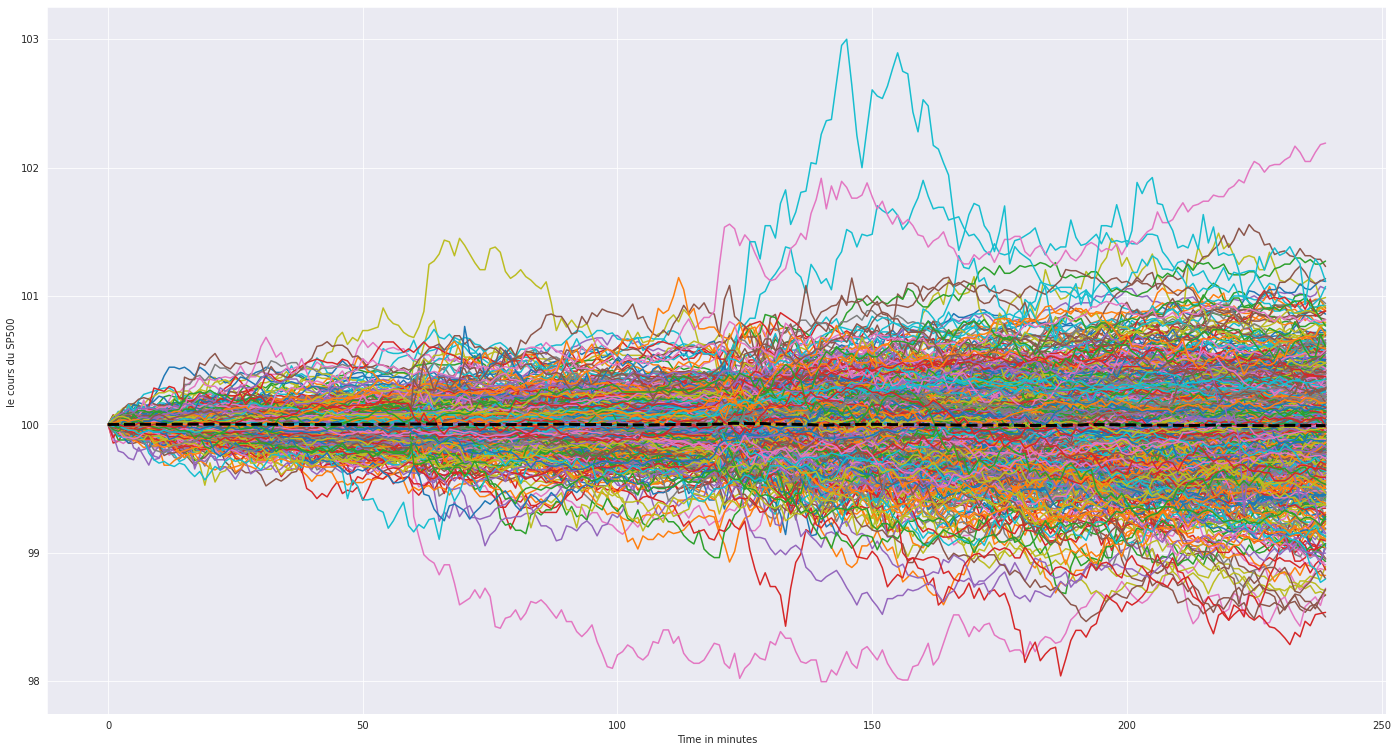

In [0]:
#plot(sp_train.values.T[2:-1,:].mean(axis = 1), ls = "--", lw= 20)
plot(sp_train.values.T[2:-1,:]);
plot(sp_train.values.T[2:-1,:].mean(axis = 1),color = "black", ls = "--", lw= 3)
xlabel("Time in minutes")
ylabel("le cours du SP500 ")

### Data normalisation

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(sp_train)

In [0]:
x = x_scaled.reshape(-1,243,1); x[:2]

array([[[-0.060996],
        [-0.747007],
        [ 0.      ],
        [-0.021965],
        ...,
        [ 0.111282],
        [ 0.080064],
        [-0.007102],
        [-0.88609 ]],

       [[-1.186965],
        [-0.850294],
        [ 0.      ],
        [-0.566776],
        ...,
        [-1.906642],
        [-1.884037],
        [-1.668498],
        [-0.88609 ]]])

In [0]:
model = build_MLP( input_shape = (243,), activation = 'relu', units = [200,100],
                  momentum=0.1, epsilon=1e-05, dropout_rate = 0.3)

In [0]:
hist = model.fit(sp_train,sp_y_train,batch_size=30, epochs=10)

Epoch 1/10
914/914 [==============================] - 0s 213us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 2/10
914/914 [==============================] - 0s 207us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 3/10
914/914 [==============================] - 0s 204us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 4/10
914/914 [==============================] - 0s 193us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 5/10
914/914 [==============================] - 0s 197us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 6/10
914/914 [==============================] - 0s 202us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 7/10
914/914 [==============================] - 0s 209us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 8/10
914/914 [==============================] - 0s 205us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 9/10
914/914 [==============================] - 0s 197us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 10/10
914/914 [==============================] - 0s 199us/step - loss: 8.589

**Remarque**: 

On voit que le modèle est pris dans un minimum local. Il faudrait approfondir cette piste, en complexifiant l'architecture et/ou en augmentant le **learning rate**.

## Convolutionnal network based model

In [0]:
from keras.layers import *
import keras

In [0]:

cnn = build_CNN(input_shape = (243,1), filters = [30,30], kernels = [4,4])
cnn.summary()
hist = cnn.fit(x,sp_y_train,batch_size=40, epochs=200)


Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_58 (Batc (None, 243, 1)            972       
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 240, 3)            15        
_________________________________________________________________
batch_normalization_59 (Batc (None, 240, 3)            960       
_________________________________________________________________
dropout_57 (Dropout)         (None, 240, 3)            0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 237, 30)           390       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 118, 30)           0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 118, 30)         

## Conv_LSTM based model

In [0]:
def lstm_block( activation = 'relu', units = [100,100, 1], momentum=0.1, epsilon=1e-05,dropout_rate = 0.3 ):
    layers = []
    for n_units in units:
        
        layers.append(Dropout(dropout_rate))
        layers.append(LSTM(units=n_units,  activation=activation, recurrent_activation="sigmoid", return_sequences=True ))
    
    return layers

In [0]:
model = keras.models.Sequential(cnn.layers[:-4]+lstm_block( activation = 'tanh', units = [50,10])
      + [Flatten(), Dense(units=1, activation='sigmoid')])


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=["accuracy"])
hist = model.fit(x,sp_y_train,batch_size=30, epochs=20)

In [0]:
hist = cnn.fit(x,sp_y_train,batch_size=40, epochs=200)


In [0]:
def lstm_block( activation = 'relu', units = [100,100, 1], momentum=0.1, epsilon=1e-05,dropout_rate = 0.3 ):
    layers = []
    for n_units in units:
        
        layers.append(tf.keras.layers.Dropout(dropout_rate))
        layers.append(tf.keras.layers.LSTM(units=n_units,  activation=activation, return_sequences=True ))
    
    return layers

In [0]:
model = tf.keras.models.Sequential(
    [tf.keras.layers.InputLayer(input_shape=(None, 1))] +
    conv1d_bolck(filters = [30,30], kernels = [4,4], stride = 1,  activation = 'relu', 
                  dropout_rate = 0.3) + [tf.keras.layers.MaxPooling1D()]+
    lstm_block( activation = 'tanh', units = [200,100]) +
    dense_block( activation = 'relu', units = [10,10,], dropout_rate = 0.3) +
    [tf.keras.layers.Dense(units=1, activation='sigmoid')]
)


model.summary()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
#optimizer = keras.optimizers.Nadam(
 #   learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=["accuracy"])
history = model.fit(x,sp_y_train,batch_size=30, epochs=200) #, callbacks=[lr_schedule])

In [0]:
history = model.fit(x,sp_y_train,batch_size=100, epochs=100)

Epoch 1/100
10/10 [==============================] - 0s 34ms/step - loss: 0.2857 - accuracy: 0.9126
Epoch 2/100
10/10 [==============================] - 0s 25ms/step - loss: 0.1614 - accuracy: 0.9213
Epoch 3/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1717 - accuracy: 0.9206
Epoch 4/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1590 - accuracy: 0.9202
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1527 - accuracy: 0.9243
Epoch 6/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1799 - accuracy: 0.9207
Epoch 7/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1780 - accuracy: 0.9171
Epoch 8/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1683 - accuracy: 0.9167
Epoch 9/100
10/10 [==============================] - 0s 25ms/step - loss: 0.1617 - accuracy: 0.9238
Epoch 10/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1732 - accuracy: 0.9211

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 60])

**Remarque**:

Le modele semble bien apprendre sur le training set au prix peut-être d'un overfitting. Il faudrait regarder ça de plus prés. 

## Fastai API for tabular data

In [0]:
from fastai.tabular import *

In [0]:
df = df_train

In [0]:
dep_var = 'Target'
cat_names = []
cont_names = sp_train.columns
procs = [FillMissing, Categorify, Normalize]

In [0]:
test = TabularList.from_df(df.iloc[600:914].copy(), cat_names=cat_names, cont_names=cont_names)

In [0]:
data = (TabularList.from_df(df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(600,914)))
                           .label_from_df(cols=dep_var)
                           #.add_test(test)
                           .databunch())

In [0]:
data.show_batch(rows=10)

openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,closeMin009,closeMin010,closeMin011,closeMin012,closeMin013,closeMin014,closeMin015,closeMin016,closeMin017,closeMin018,closeMin019,closeMin020,closeMin021,closeMin022,closeMin023,closeMin024,closeMin025,closeMin026,closeMin027,closeMin028,closeMin029,closeMin030,closeMin031,closeMin032,closeMin033,closeMin034,closeMin035,closeMin036,closeMin037,closeMin038,closeMin039,closeMin040,closeMin041,closeMin042,closeMin043,closeMin044,closeMin045,closeMin046,closeMin047,closeMin048,closeMin049,closeMin050,closeMin051,closeMin052,closeMin053,closeMin054,closeMin055,closeMin056,closeMin057,closeMin058,closeMin059,closeMin060,closeMin061,closeMin062,closeMin063,closeMin064,closeMin065,closeMin066,closeMin067,closeMin068,closeMin069,closeMin070,closeMin071,closeMin072,closeMin073,closeMin074,closeMin075,closeMin076,closeMin077,closeMin078,closeMin079,closeMin080,closeMin081,closeMin082,closeMin083,closeMin084,closeMin085,closeMin086,closeMin087,closeMin088,closeMin089,closeMin090,closeMin091,closeMin092,closeMin093,closeMin094,closeMin095,closeMin096,closeMin097,closeMin098,closeMin099,closeMin100,closeMin101,closeMin102,closeMin103,closeMin104,closeMin105,closeMin106,closeMin107,closeMin108,closeMin109,closeMin110,closeMin111,closeMin112,closeMin113,closeMin114,closeMin115,closeMin116,closeMin117,closeMin118,closeMin119,closeMin120,closeMin121,closeMin122,closeMin123,closeMin124,closeMin125,closeMin126,closeMin127,closeMin128,closeMin129,closeMin130,closeMin131,closeMin132,closeMin133,closeMin134,closeMin135,closeMin136,closeMin137,closeMin138,closeMin139,closeMin140,closeMin141,closeMin142,closeMin143,closeMin144,closeMin145,closeMin146,closeMin147,closeMin148,closeMin149,closeMin150,closeMin151,closeMin152,closeMin153,closeMin154,closeMin155,closeMin156,closeMin157,closeMin158,closeMin159,closeMin160,closeMin161,closeMin162,closeMin163,closeMin164,closeMin165,closeMin166,closeMin167,closeMin168,closeMin169,closeMin170,closeMin171,closeMin172,closeMin173,closeMin174,closeMin175,closeMin176,closeMin177,closeMin178,closeMin179,closeMin180,closeMin181,closeMin182,closeMin183,closeMin184,closeMin185,closeMin186,closeMin187,closeMin188,closeMin189,closeMin190,closeMin191,closeMin192,closeMin193,closeMin194,closeMin195,closeMin196,closeMin197,closeMin198,closeMin199,closeMin200,closeMin201,closeMin202,closeMin203,closeMin204,closeMin205,closeMin206,closeMin207,closeMin208,closeMin209,closeMin210,closeMin211,closeMin212,closeMin213,closeMin214,closeMin215,closeMin216,closeMin217,closeMin218,closeMin219,closeMin220,closeMin221,closeMin222,closeMin223,closeMin224,closeMin225,closeMin226,closeMin227,closeMin228,closeMin229,closeMin230,closeMin231,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240,Target,target
-0.4161,-1.1274,0.0000,1.2545,1.4783,1.6613,1.4168,0.6300,0.8655,0.5617,0.2418,0.2118,0.6362,0.6115,0.5677,0.5278,0.9116,0.5016,0.6748,0.8217,0.7815,0.6162,0.7580,0.7509,1.0585,0.8932,0.7278,1.0022,0.9869,0.9946,1.1212,1.2068,1.1773,1.1605,1.0250,1.1517,1.2538,0.9814,0.9571,0.9542,0.9499,0.8172,0.8009,0.7900,0.7903,0.6624,0.4149,0.5186,0.7279,0.6344,0.6290,0.9227,0.9039,0.9121,0.8036,0.8029,0.7793,0.8821,1.0758,1.0662,1.0694,1.0703,0.8879,0.9386,1.0503,0.9971,1.0471,1.0294,1.0322,1.0364,0.9619,0.9152,0.9157,0.9248,1.0718,0.9241,1.0674,0.8209,0.8070,0.9343,0.8804,0.9535,0.8772,0.8658,1.1441,1.2736,1.2051,1.3459,1.2625,1.1305,1.1327,1.1472,1.3386,1.3339,1.5248,1.6625,1.7871,2.0491,2.0220,2.2273,2.1569,2.0784,2.0802,2.0237,2.0022,2.0686,1.9859,1.9406,1.9470,1.9650,1.9560,1.8915,1.8818,1.8025,1.7310,1.6417,1.5623,1.5699,1.7046,1.5655,1.5714,1.6189,1.5228,1.5201,1.6656,1.4263,1.6611,1.5134,1.2167,0.9877,1.0612,1.0995,1.0611,0.7987,0.9549,0.8440,1.0994,0.9919,0.8444,0.9429,0.9322,0.8394,0.9972,0.9947,1.0406,1.2011,1.1985,1.3302,1.2787,1.1765,1.0852,1.1155,0.9941,1.0957

In [0]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

In [0]:
learn.fit(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.479961,0.526335,0.799363,00:00
1,0.311117,0.081639,0.977707,00:00
2,0.223599,0.176661,0.936306,00:00
3,0.184586,0.052629,0.971338,00:00
4,0.143433,0.073473,0.984076,00:00
5,0.113916,0.078807,0.980892,00:00
6,0.094956,0.114374,0.955414,00:00
7,0.077320,0.062629,0.977707,00:00
8,0.065385,0.035062,0.993631,00:00
9,0.055308,0.002578,1.000000,00:00


## Time séries forcasting

In [0]:
import tensorflow as tf

In [0]:
ts_data = x[:,2:, 0].T

Text(0, 0.5, 'le cours du SP500 ')

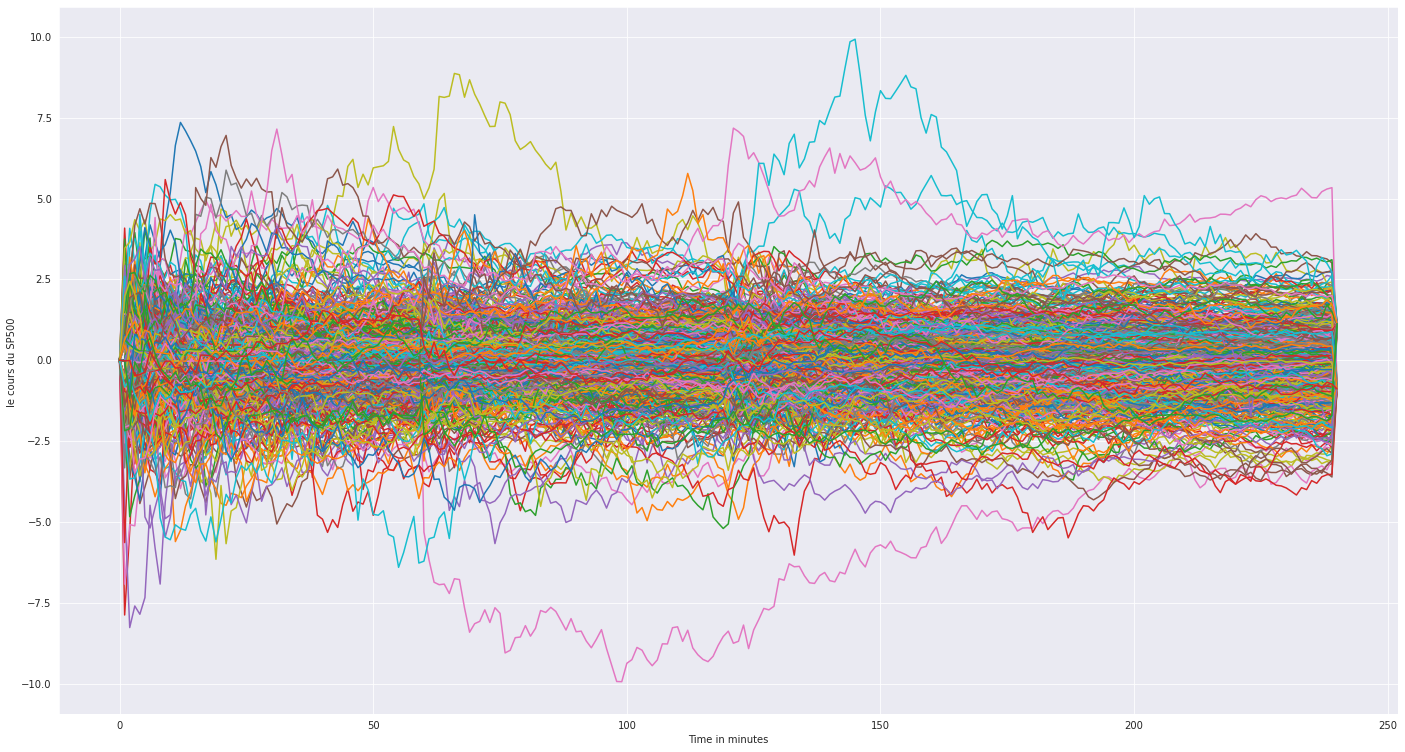

In [0]:
plot(ts_data);
xlabel("Time in minutes")
ylabel("le cours du SP500 ")

In [0]:
ts_data.shape

(1, 241, 914)

In [0]:
def train_test_split(series):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(241).prefetch(1)

In [0]:
windowed_dataset2(ts_data)

In [0]:
sd = windowed_dataset2(a); sd

<PrefetchDataset shapes: ((None, 2, 1), (None, 2, 1)), types: (tf.int64, tf.int64)>